# Timeseries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Loading Data
df=pd.read_csv('exchange_rate.csv',parse_dates=True)
# Converting data type from object to datetime
df['date'] = pd.to_datetime(df['date'])
# Making Date as index and frequence as Daily
df = df.set_index('date').asfreq('D').fillna(method='ffill')
# basic Evaluation
df.head()
df.info()
df.describe()
df[df.duplicated()]
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7648 entries, 1990-01-01 to 2010-12-09
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7648 non-null   float64
dtypes: float64(1)
memory usage: 119.5 KB


Ex_rate    0
dtype: int64

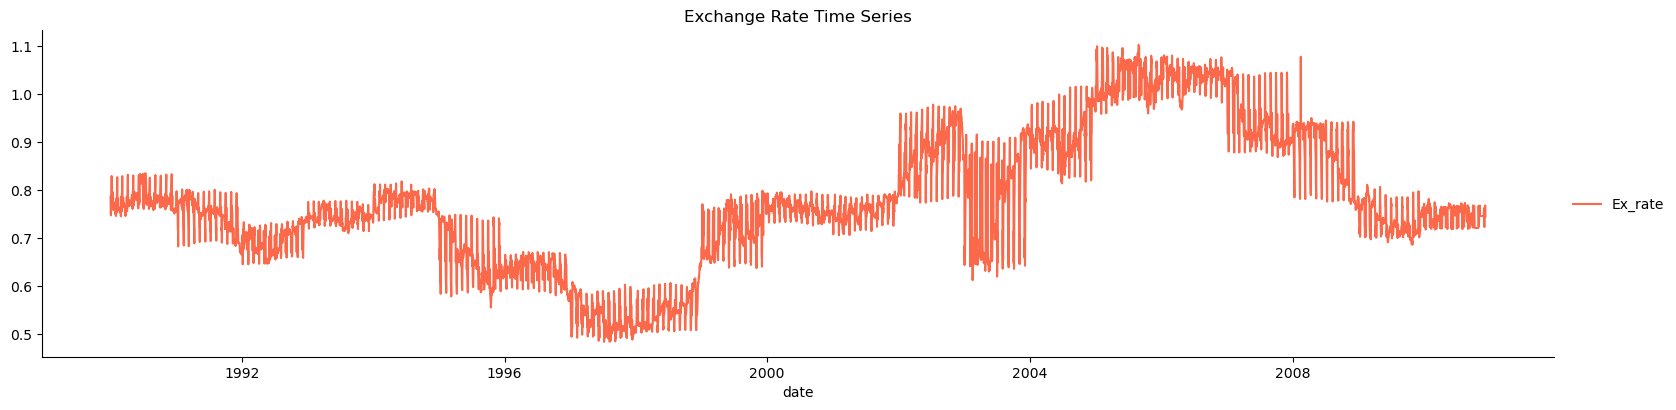

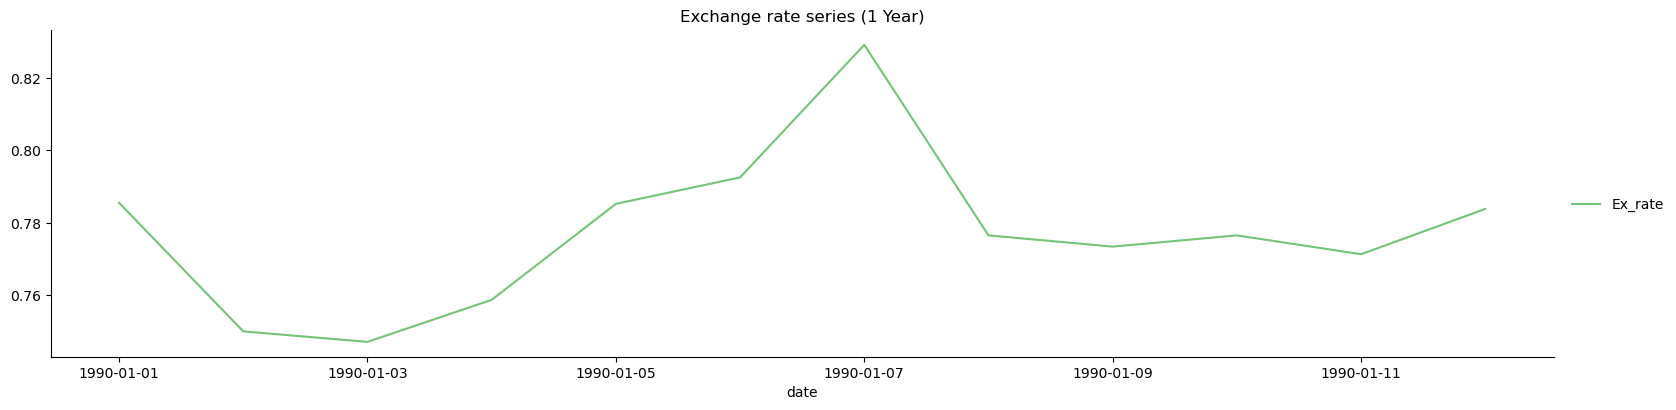

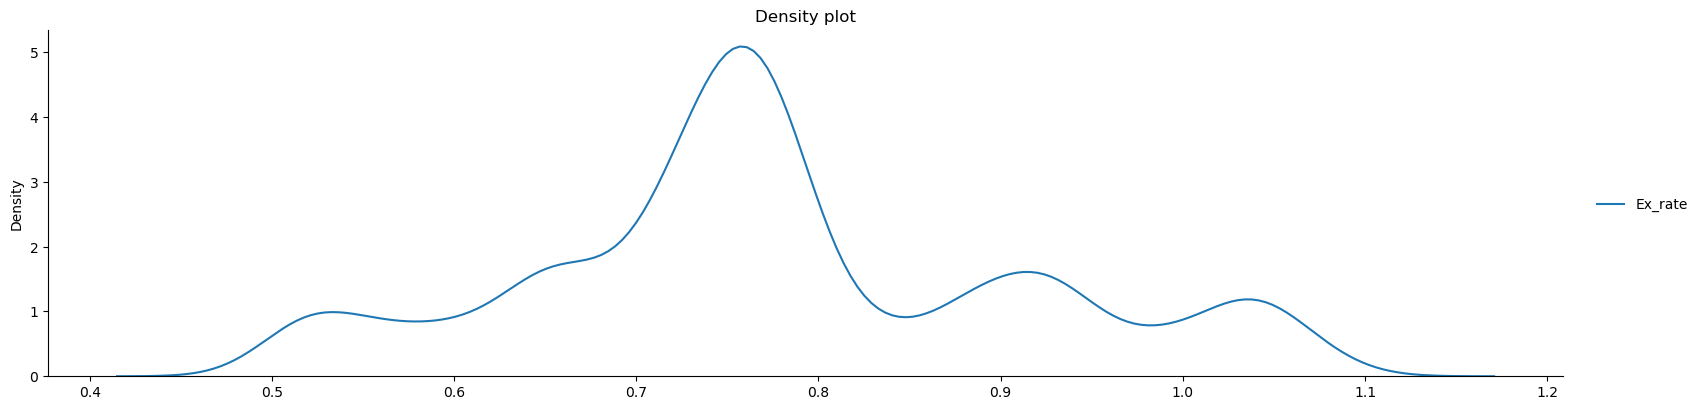

In [68]:
# Data Visualization
# Line plot 
sns.relplot(df,kind='line',height=4,aspect=4,palette='Reds')
plt.title('Exchange Rate Time Series')
# Line plot for a year
sns.relplot(df.head(12),kind='line',height=4,aspect=4,palette='Greens')
plt.title('Exchange rate series (1 Year)')
# Density plot for analysing skewness
sns.displot(df,kind='kde',height=4,aspect=4)
plt.title('Density plot')
plt.show()

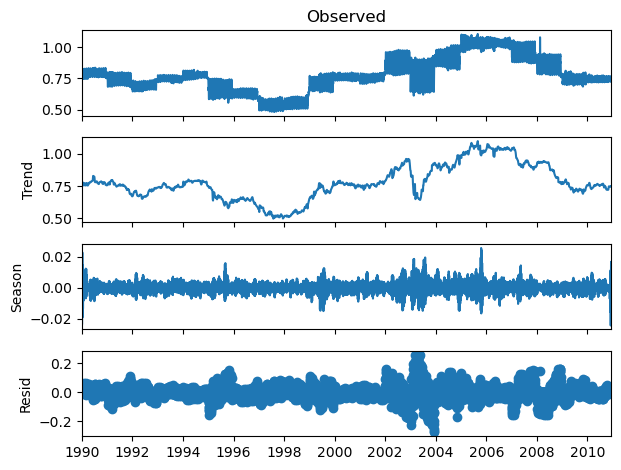

In [9]:
# ETS Decomposition plot
from statsmodels.tsa.seasonal import STL
res=STL(df,robust=True).fit()
res.plot()
plt.show()

In [78]:
# Checking for Stationary 
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    if adfuller(data)[1] > 0.05:
        print('Data is not Stationary')
    else:
        print('Data is stationary')

adf_test(df)
print()
# Performing differentiation
from statsmodels.tsa.statespace.tools import diff
diff1=diff(df,k_diff=2)
print('After differentation')
adf_test(diff1)


Data is not Stationary

After differentation
Data is stationary


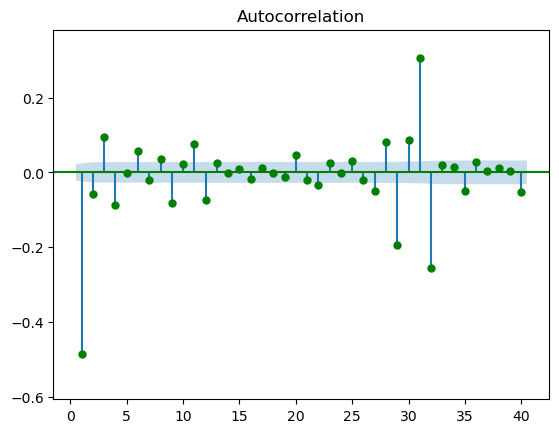

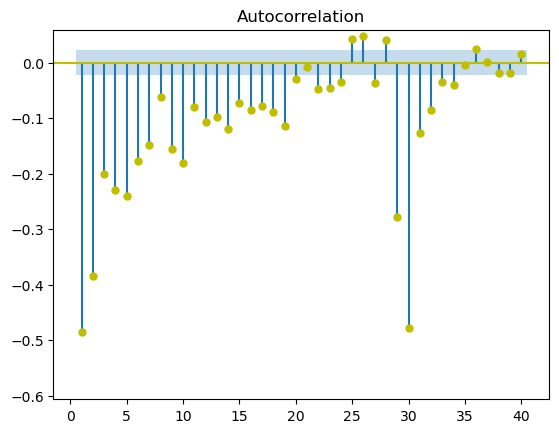

In [79]:
# Finding MA(q) and Ai(p) orders
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff1, lags=40, zero=False,color='green',title='Autocorrelation',auto_ylims=True)
plot_pacf(diff1, lags=40, zero=False,color='y',title='Autocorrelation',auto_ylims=True)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7648
Model:                 ARIMA(2, 1, 2)   Log Likelihood               18066.273
Date:                Mon, 03 Mar 2025   AIC                         -36122.546
Time:                        02:34:21   BIC                         -36087.835
Sample:                    01-01-1990   HQIC                        -36110.638
                         - 12-09-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1581      0.079      1.995      0.046       0.003       0.314
ar.L2          0.3960      0.060      6.572      0.000       0.278       0.514
ma.L1         -0.3412      0.077     -4.419      0.0

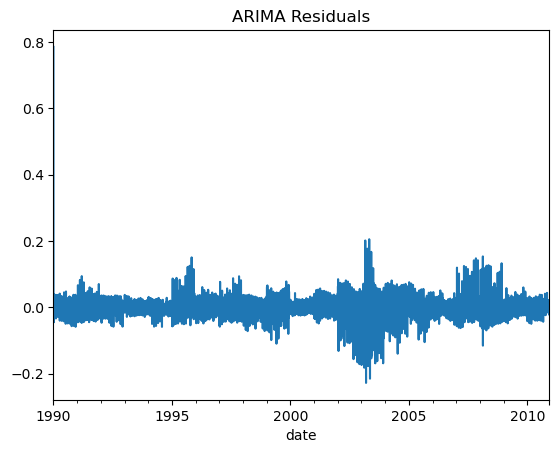

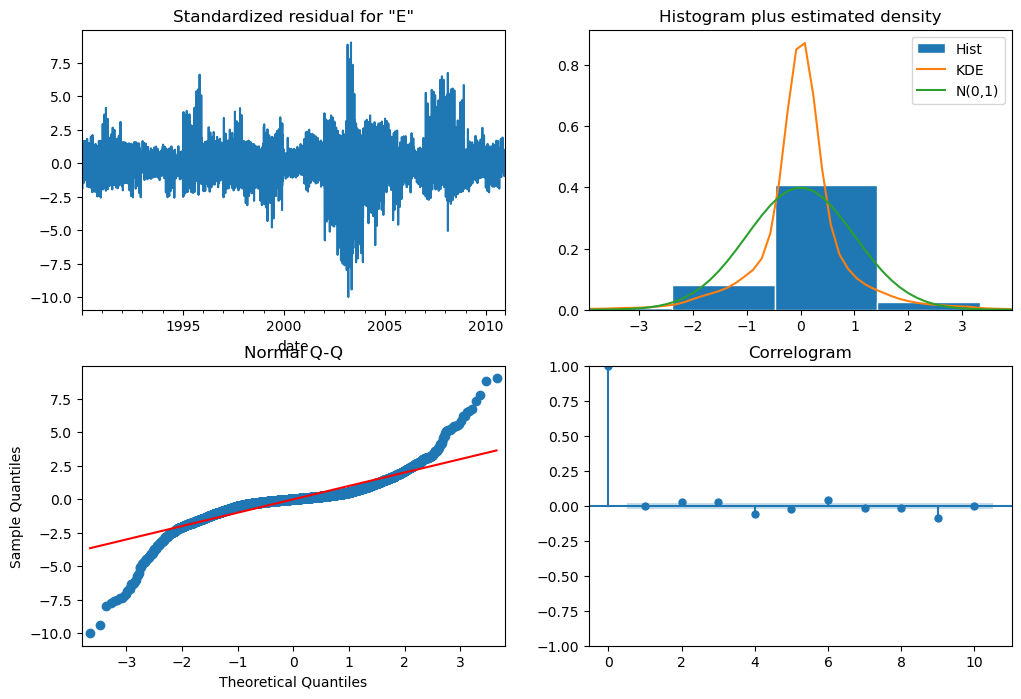

In [21]:
from statsmodels.tsa.arima.model import ARIMA
# Building ARIMA model
arima_model = ARIMA(df["Ex_rate"], order=(2, 1, 2)).fit()
print(arima_model.summary())
# Residual analysis
arima_model.resid.plot(title="ARIMA Residuals")
plt.show()
# Diagnosing model
arima_model.plot_diagnostics(figsize=(12,8));

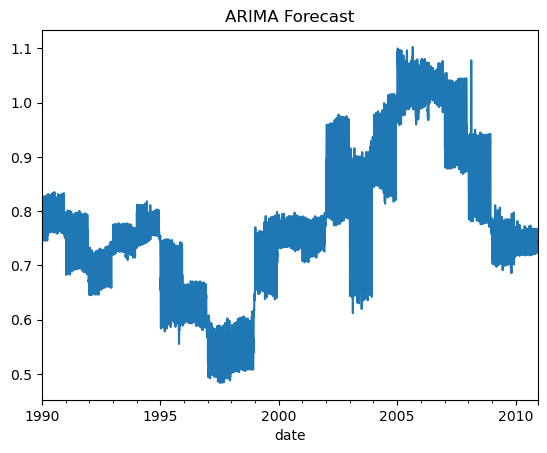

In [20]:
# Forecasting Data
forecast_arima = arima_model.forecast(steps=30)
df['Ex_rate'].plot()
plt.plot(pd.date_range(df.index[-1], periods=30, freq='D'), forecast_arima, color='red')
plt.title('ARIMA Forecast')
plt.show()

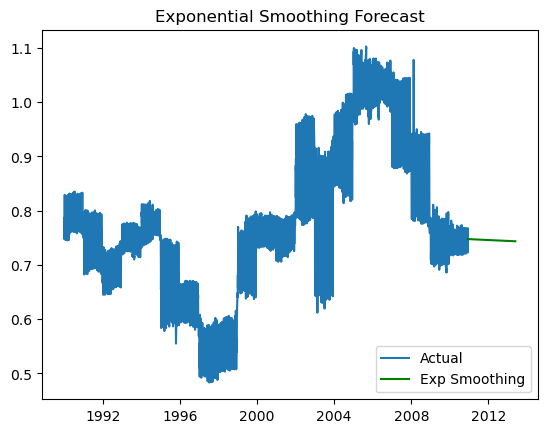

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Exponential Smoothing Model building
exp_smooth = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()
# Forecasting 
forecast_exp = exp_smooth.forecast(900)
forecast_exp
# Visualizing Forecasted result
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=900, freq='D'), forecast_exp, color='green', label='Exp Smoothing')
plt.legend(loc='lower right')
plt.title('Exponential Smoothing Forecast')
plt.show()

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluating Models
mae_arima = mean_absolute_error(df['Ex_rate'].iloc[-30:], forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(df['Ex_rate'].iloc[-30:], forecast_arima))
mae_exp = mean_absolute_error(df['Ex_rate'].iloc[-900:], forecast_exp)
rmse_exp = np.sqrt(mean_squared_error(df['Ex_rate'].iloc[-900:], forecast_exp))
# Displaying Results
print(f'ARIMA -\nMAE: {mae_arima}\nRMSE: {rmse_arima}')
print(f'Exp Smoothing - \nMAE: {mae_exp}\nRMSE: {rmse_exp}')

ARIMA -
MAE: 0.003890688486515444
RMSE: 0.008234341621731318
Exp Smoothing - 
MAE: 0.038041824407608
RMSE: 0.05772925409901884


### Model comparsion

    ARIMA Model :

        1.Lower MAE and RMSE indicate that ARIMA provides highly accurate forecasts with minimal deviation from actual values.
        2.ARIMA effectively captures trends and fluctuations in the exchange rate dataset.

        Pros: 
        1.Captures temporal dependencies and used it for future predection.
        2.Accurate Predictions and Handles Non stationarity effectively.

        Cons:
        1.Requires Manual Parameter Selection
        2.More compuation is required

    Exponential Smoothing:

        1.Higher MAE and RMSE indicate that Exponential Smoothing forecasts have little large errors and are less reliable for exchange rate prediction  comparing with ARIMA.
        2.The model may struggle with capturing sudden fluctuations or trends.

        Pros:
        1.Simple, Efficient and Fast in computation
        2.Eassy to handle satable data

        Cons:
        1.Difficult to find patterns and struggle with large data 
        2.Lack of adaptability and more errors

### Conclusion

    ARIMA MODEL : MAE = 0.0039 and RMSE = 0.0082.
    Exponential Smoothing Model : MAE = 0.0380 and RMSE = 0.0577.
    
    ARIMA is the preferred model for forecasting exchange rates in this dataset due to its lower prediction errors.Exponential Smoothing is less suitable, possibly due to the exchange rate's non-linear trends and fluctuations, which ARIMA can model better with its differencing and autoregressive components.ARIMA is more suitable for financial data like exchange rates, which exhibit non-stationary behavior and require capturing historical dependencies.However, Exponential Smoothing may still be useful in situations where quick, approximate forecasts are needed without computational overhead.
